# Imports

In [37]:
import cv2 as cv
import shutil
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

# Load Image

In [38]:
img1 = cv.imread('HSV Model 1.png')
img2 = cv.imread('HSV Model 2.png')
img3 = cv.imread('HSV Model 3.jpg')

resized_img1 = cv.resize(img1, (500, 500))
resized_img2 = cv.resize(img2, (500, 500))
resized_img3 = cv.resize(img3, (500, 500))

img = np.hstack((resized_img1, resized_img2, resized_img3))

yellow_test = cv.imread('yellow_test.png')
test_rgb = cv.cvtColor(yellow_test, cv.COLOR_BGR2RGB)

rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [39]:
mypath = 'train'

classes = [str(i).zfill(3) for i in range(0, 60)]

files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if f.endswith('.png')]

for i in range(len(files)):
    if files[i][:3] in classes:
        
        # create a folder for each class
        folderName = files[i][:3]
        if folderName == '000': folderName = mypath + '/' + '0'
        else: folderName = mypath + '/' + folderName.lstrip('0')
        if not os.path.exists(folderName): os.mkdir(folderName)
        
        # move the file to the corresponding folder
        shutil.move(mypath + '/' + files[i], folderName + '/' + files[i])


In [40]:
# remove .DS_Store file
if os.path.exists(mypath + '/.DS_Store'):
    os.remove(mypath + '/.DS_Store')

# Load images
count = 0
images = []
classNo = []
folder = os.listdir(mypath)
classes=len(folder)
for x in range (0,len(folder)):
    files = os.listdir(mypath+"/"+str(count))
    for y in files:
        curImg = cv.imread(mypath+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    count +=1
images = np.array(images, dtype=object)
classNo = np.array(classNo)
print('Done')


Done


# Randomly Choose an image

In [174]:
def random_img():
    # randomly select and image
    idx = np.random.randint(0, len(images)-1)
    # idx = 606
    test_img = images[idx].copy()
    test_img = cv.resize(test_img, (500, 500))
    print(f"Image ID = {idx}")
    print(f"Image Class = {classNo[idx]}")
    return test_img
test_img = random_img()

Image ID = 1038
Image Class = 10


# Pre-process

## HSV color range threshold

In [185]:
def red_mask(img):
    low_lower_red = np.array([0, 100, 20])
    low_upper_red = np.array([10, 255, 255])

    high_lower_red = np.array([160, 100, 20])
    high_upper_red = np.array([179, 255, 255])

    red_low = cv.inRange(img, low_lower_red, low_upper_red)
    red_high = cv.inRange(img, high_lower_red, high_upper_red)
    mask = red_low + red_high
    return cv.threshold(mask, 0, 255, cv.THRESH_BINARY_INV)
    

In [186]:
def blue_mask(img):
    lower_blue = np.array([90, 50, 20])
    upper_blue = np.array([140, 255, 255])
    mask = cv.inRange(img, lower_blue, upper_blue)
    return cv.threshold(mask, 0, 255, cv.THRESH_BINARY_INV)

In [187]:
def yellow_mask(img):
    lower_yellow = np.array([5, 80, 20])
    upper_yellow = np.array([50, 255, 255])
    mask = cv.inRange(img, lower_yellow, upper_yellow)
    return cv.threshold(mask, 0, 255, cv.THRESH_BINARY_INV)

In [45]:
def hsv_color_range_threshold(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mask = red_mask(hsv) + blue_mask(hsv) + yellow_mask(hsv)
    _, thresh = cv.threshold(mask, 0, 255, cv.THRESH_BINARY_INV)
    return thresh
    

## HSV Hue and Saturation Thresholding

In [46]:
def hsv_threshold(img):
    hsv = cv.cvtColor(test_img, cv.COLOR_BGR2HSV)

    h, s, _ = cv.split(hsv)

    _, h_thresh = cv.threshold(h, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    _, s_thresh = cv.threshold(s, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    return cv.bitwise_and(h_thresh, s_thresh)

In [47]:
# and_thresh = cv.bitwise_and(hsv_color_range_threshold(test_img), hsv_threshold(test_img))
# or_thresh = cv.bitwise_or(hsv_color_range_threshold(test_img), hsv_threshold(test_img))

In [48]:
def get_bounding_box(thresh):
    # cv.contourArea
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    return sorted(contours, key=cv.contourArea, reverse=True)

In [151]:
def draw_contours(img, contours):
    height, width = img.shape[:2]
    cnts = []
    for c in contours:
        area = cv.contourArea(c)
        x, y, w, h = cv.boundingRect(c)
        if area > 1000 and w > 10 and h > 10 and x > 10 and y > 10 and x + w < width - 10 and y + h < height - 10:
            cnts.append(c)
    largest_contour = max(cnts, key=cv.contourArea) if cnts else None
    if largest_contour is not None:
        x, y, w, h = cv.boundingRect(largest_contour)
        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
    

# Display Image

In [272]:
def plot(img, title=None):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

# Test

In [277]:
def test(img):
    # median blur
    rgb = img.copy()
    rgb = cv.cvtColor(rgb, cv.COLOR_BGR2RGB)
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    hsv = cv.medianBlur(hsv, 5)
    # biliteral filter
    hsv = cv.bilateralFilter(hsv, 9, 75, 75)
    
    
    # color_range_thresh = hsv_color_range_threshold(hsv)
    red_thresh = red_mask(hsv)[1]
    blue_thresh = blue_mask(hsv)[1]
    yellow_thresh = yellow_mask(hsv)[1]
    hsv_thresh = hsv_threshold(hsv)
    # and_thresh = cv.bitwise_and(color_range_thresh, hsv_thresh)
    # or_thresh = cv.bitwise_or(color_range_thresh, hsv_thresh)
    
    threshs = [red_thresh, blue_thresh, yellow_thresh]

    # hsv = cv.erode(hsv, np.ones((3,3), np.uint8), iterations=1)
    # hsv = cv.morphologyEx(hsv, cv.MORPH_OPEN, np.ones((3,3), np.uint8))
    # hsv = cv.dilate(hsv, np.ones((5,5), np.uint8), iterations=1)
    
    for i in threshs:
        h, w = i.shape[:2]
        mask = np.zeros((h+2, w+2), np.uint8)
        cv.floodFill(i, mask, (0,0), 255)

    # invert threshs
    threshs = [cv.bitwise_not(i) for i in threshs]
    
    hsv = cv.cvtColor(hsv, cv.COLOR_BGR2RGB)
    contours = []
    for i in threshs:
        for j in get_bounding_box(i):
            contours.append(j)
    
    draw_contours(rgb, contours)
    
    # hsv = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    
    plot(rgb, 'original image')
    thresh_name = ['red', 'blue', 'yellow']
    for i in threshs:
        plot(i, thresh_name.pop(0))

Image ID = 3830
Image Class = 54


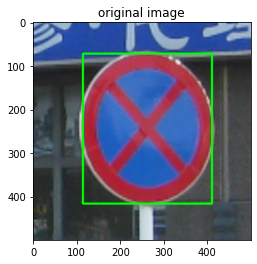

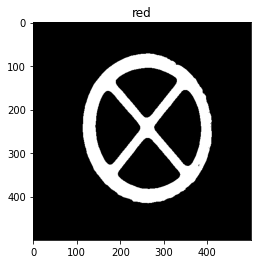

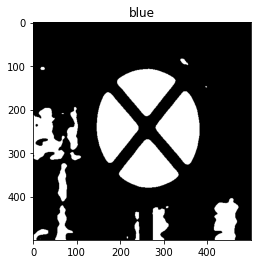

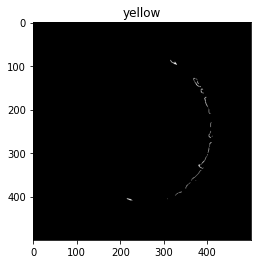

In [279]:
test_img = random_img()
test(test_img)

In [ ]:
# accuracy evaluation
